In [74]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [33]:

def read_file (file_path):
    try: 
        with open(file_path, 'r', encoding= "utf-8") as f:
            df = pd.read_csv(f)
            print (f'file loaded successfully with {df.shape[0]} rows')

    except FileNotFoundError:
        print ('File not found')
    
    return df


file_path = "insurance_risk_dataset.csv"
df = read_file(file_path)


file loaded successfully with 3000 rows


In [34]:
df.head()

,client_id,age,gender,driving_experience,car_model,year_of_manufacture,car_usage,annual_mileage,location,has_caused_accident,num_of_accidents,vehicle_value,risk_level
0,CL0001,56,Male,35,Toyota Premio,2019,Commercial,21284,Kisumu,Yes,1,2734489,Medium
1,CL0002,28,Male,8,Toyota Prado,2008,Personal,26023,Thika,Yes,3,2638242,High
2,CL0003,41,Male,20,Toyota Vitz,2010,Personal,12433,Nakuru,No,0,1291743,Low
3,CL0004,50,Female,29,Toyota Premio,2016,Personal,37480,Nairobi,No,0,1417040,Low
4,CL0005,59,Male,38,Toyota Prado,2020,Commercial,10189,Nakuru,No,0,3775709,Low


In [35]:
def clean_df(df):
    #Drop duplicates
    df = df.drop_duplicates()

    #Drop null values
    df = df.dropna()

    #drop irrelevant columns
    df = df.drop('client_id', axis =1)


    return df


df = clean_df(df)
df.sample(3)

,age,gender,driving_experience,car_model,year_of_manufacture,car_usage,annual_mileage,location,has_caused_accident,num_of_accidents,vehicle_value,risk_level
1563,49,Female,27,Toyota Premio,2019,PSV,47485,Thika,No,0,2511562,Low
2700,55,Female,35,Subaru Forester,2007,PSV,15458,Thika,No,0,2095164,Low
2345,23,Male,4,Toyota Prado,2021,Commercial,42375,Nakuru,No,0,1252648,Low


In [88]:
def preprocess(df):

    encoder = LabelEncoder()

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = encoder.fit_transform(df[col])

    return df,encoder


df, encoder = preprocess(df)
df.sample(2)


,age,gender,driving_experience,car_model,year_of_manufacture,car_usage,annual_mileage,location,has_caused_accident,num_of_accidents,vehicle_value,risk_level,cluster
2126,30,1,8,2,2018,0,17240,0,1,1,3426759,2,0
2835,23,1,0,2,2020,2,23336,2,0,0,4693319,1,0


In [80]:
def split_train(df):
    y = df['risk_level']
    X = df.drop('risk_level', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size= 0.2, stratify= y)

    return X, y, X_train, X_test, y_train, y_test


X, y, X_train, X_test, y_train, y_test = split_train(df)

In [53]:
model = RandomForestClassifier(
        n_estimators = 100,
        max_depth = None,
        random_state =42,
        class_weight = 'balanced'
        )   

model.fit(X_train, y_train) 

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
predictions = model.predict(X_test)

print('accuracy_score', accuracy_score(y_test, predictions))
print('classification_report', classification_report(y_test, predictions))

accuracy_score 1.0
classification_report               precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00       392
           2       1.00      1.00      1.00       118

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [56]:
import pandas as pd

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

num_of_accidents       0.644976
has_caused_accident    0.296616
vehicle_value          0.011334
annual_mileage         0.010425
year_of_manufacture    0.007810
driving_experience     0.007499
age                    0.006648
car_model              0.005446
location               0.005344
car_usage              0.002479
gender                 0.001423
dtype: float64


In [81]:
from sklearn.preprocessing import StandardScaler

# Drop the target variable if present


# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
df['cluster'] = clusters

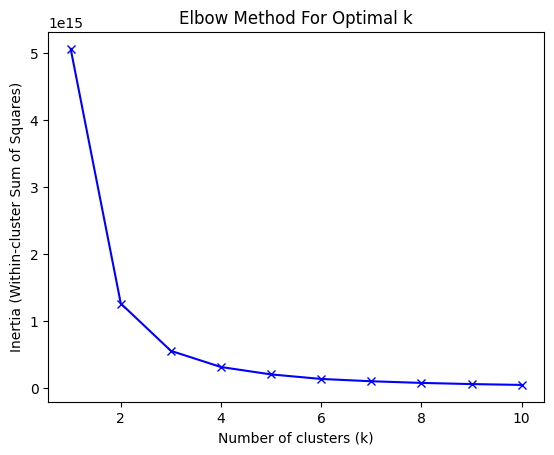

In [83]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming X is your dataset (scaled or normalized)
inertia_values = []
k_values = range(1, 11)  # Check k from 1 to 10 (can adjust)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

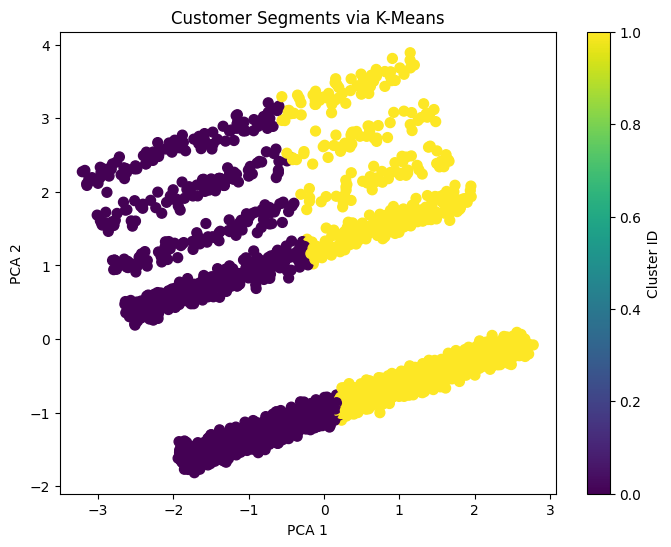

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Customer Segments via K-Means')
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [84]:
from sklearn.metrics import silhouette_score

best_k = 2  # Replace with k chosen from elbow
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

sil_score = silhouette_score(X, cluster_labels)
print(f'Silhouette Score for k={best_k}: {sil_score}')

Silhouette Score for k=2: 0.6272519011704226


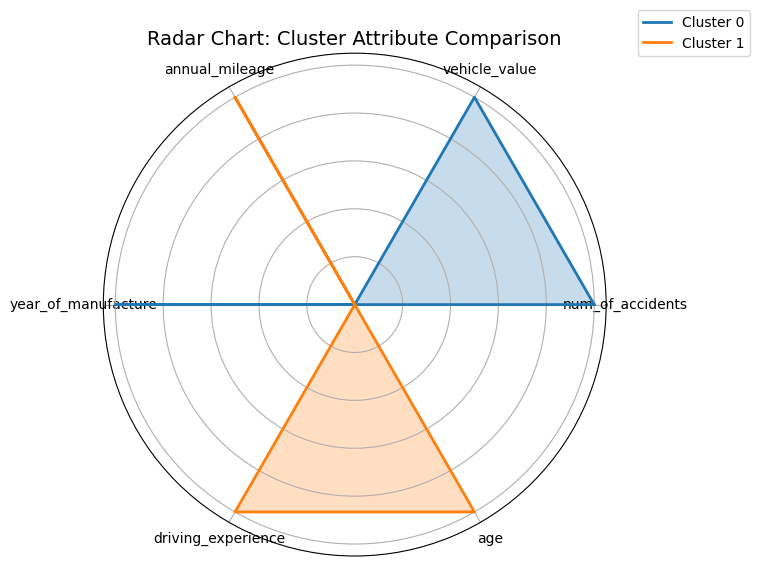

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features for comparison
features = ['num_of_accidents', 'vehicle_value', 'annual_mileage',
            'year_of_manufacture', 'driving_experience', 'age']

# Step 2: Compute average per cluster
cluster_means = df.groupby('cluster')[features].mean()

# Step 3: Normalize the values
scaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(scaler.fit_transform(cluster_means), 
                                    columns=features, 
                                    index=cluster_means.index)

# Step 4: Prepare for radar chart
labels = features
num_vars = len(labels)

# Set up angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in cluster_means_scaled.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=f'Cluster {i}', linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Format radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([])
ax.set_title("Radar Chart: Cluster Attribute Comparison", size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

Key Observations:

Feature	Cluster 0 (Blue)	Cluster 1 (Orange)	Interpretation

num_of_accidents	High	Low	Cluster 0 likely represents high-risk drivers.

vehicle_value	High	Low	Cluster 0 drives higher-value cars.

annual_mileage	Low	High	Cluster 1 drives more. Possibly commuters or long-distance drivers.

year_of_manufacture	Slightly higher in C0	Zero (low) in C1	Cluster 0 has newer cars.

driving_experience	Low	High	Cluster 1 is more experienced.

age	Low	High	Cluster 1 is older.

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import joblib

# Training features
categorical_cols = ['gender', 'car_model', 'car_usage', 'location']
numeric_cols = ['age', 'driving_experience', 'year_of_manufacture', 'annual_mileage',
                'has_caused_accident', 'num_of_accidents', 'vehicle_value']

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline with KMeans
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2, random_state=42))  # or whatever value of k Murango settled on
])

# Fit pipeline on raw training data (DataFrame with same column names as above)
pipeline.fit(X_train)

# Save the entire pipeline
joblib.dump(pipeline, 'kmeans_pipeline.joblib')


['kmeans_pipeline.joblib']

In [ ]:
# Load pipeline
pipeline = joblib.load('kmeans_pipeline.joblib')

# New customer as raw data
new_customer = pd.DataFrame([{
    'age': 35,
    'gender': 'Male',
    'driving_experience': 10,
    'car_model': 'Sedan',
    'year_of_manufacture': 2018,
    'car_usage': 'Personal',
    'annual_mileage': 12000,
    'location': 'Nairobi',
    'has_caused_accident': 0,
    'num_of_accidents': 0,
    'vehicle_value': 25000
}])

# Predict cluster
predicted_cluster = pipeline.predict(new_customer)
print(f"Predicted Cluster: {predicted_cluster[0]}")

Predicted Cluster: 1
